In [3]:
import pandas as pd
import numpy as np

In [4]:
data = pd.read_csv('/content/course.csv', index_col='date', parse_dates=True)
data = data[['open', 'high', 'low', 'close', 'volume']]


In [7]:
data['close_diff'] = data['close'].diff()
data = data[1:]
data = data.drop(columns = 'close')

In [8]:
data

,open,high,low,volume,close_diff
date,,,,,
2014-04-25,-1.128959,-1.128100,-1.136704,1.922197,0.001636
2014-04-28,-1.133861,-1.108301,-1.125475,1.486595,0.031416
2014-04-29,-1.102484,-1.111547,-1.115568,0.028657,-0.011781
2014-04-30,-1.125363,-1.133943,-1.122833,0.433389,-0.003600
2014-05-01,-1.130593,-1.138487,-1.130099,-0.030344,-0.013090
...,...,...,...,...,...
2019-11-07,2.255509,2.253991,2.298550,-0.808006,0.006545
2019-11-08,2.260085,2.290019,2.298220,-0.890224,0.055632
2019-11-11,2.304535,2.303976,2.330254,-1.049785,0.004909


In [21]:
data = data[1:]

In [22]:
import pandas as pd
import numpy as np

# Пример данных (замените на ваши реальные данные)

# Формирование последовательностей из последних 20 шагов (features)
sequence_length = 20
sequences = []
labels = []
# Используем данные с 20 таймстепами для предсказания следующего изменения close
for i in range(len(data) - sequence_length):
    seq = data.iloc[i:i+sequence_length][['open', 'high', 'low', 'close_diff', 'volume']].values
    # Метка 1 если "close" поднимется, 0 если снизится
    label = data['close_diff'] > 0
    sequences.append(seq)
    labels.append(label)

X = np.array(sequences)
y = np.array(labels)


In [26]:
X_train

,open,high,low,volume
date,,,,
2018-10-05,1.235429,1.224758,1.204434,-0.022114
2014-07-03,-1.076010,-1.085581,-1.076929,-0.921352
2014-12-04,-0.864215,-0.856105,-0.857643,0.077936
2015-07-14,-0.960307,-0.956724,-0.953085,-0.440959
2019-06-06,1.686801,1.705131,1.698487,-0.594789
...,...,...,...,...
2018-08-29,1.164177,1.187756,1.192215,-0.584308
2018-10-18,1.152738,1.139069,1.111634,0.119501
2019-06-17,1.889117,1.892088,1.927350,-1.069754


In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np


# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Преобразуем в тензоры PyTorch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

train_data = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)

# Определение модели VAE
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(VAE, self).__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim

        # Энкодер
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim * 2)  # mean and log-variance
        )

        # Декодер
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim),
            #nn.Sigmoid()  # Используем Sigmoid для нормализации выхода
        )

    def encode(self, x):
        h = self.encoder(x)
        mu, log_var = h.chunk(2, dim=-1)
        return mu, log_var

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        reconstructed_x = self.decode(z)
        return reconstructed_x, mu, log_var

    def loss_function(self, reconstructed_x, x, mu, log_var):
        # MSE Loss
        MSE = nn.functional.mse_loss(reconstructed_x[:,:,4], x[:,:,4], reduction='sum')

        # KL Divergence
        KL_divergence = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

        return MSE + KL_divergence

# Настройка модели и оптимизатора
vae = VAE(input_dim=X_train.shape[2], latent_dim=32)
optimizer = optim.Adam(vae.parameters(), lr=0.001)

# Для отслеживания потерь
losses = []

# Обучение модели
epochs = 1000
for epoch in range(epochs):
    vae.train()
    running_loss = 0.0
    for batch_data, _ in train_loader:
        optimizer.zero_grad()

        # Прямой проход
        reconstructed_batch, mu, log_var = vae(batch_data)

        # Вычисление потерь
        loss = vae.loss_function(reconstructed_batch, batch_data, mu, log_var)
        loss.backward()

        # Обновление параметров
        optimizer.step()
        running_loss += loss.item()

    losses.append(running_loss / len(train_loader))
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader)}')

# Построение графика потерь
plt.plot(range(epochs), losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.show()

# Прогнозирование на тестовых данных

# Получаем скрытые представления (latent variables) из энкодера
vae.eval()

with torch.no_grad():
    reconstructed_test, mu_test, log_var_test = vae(X_test_tensor)

    # Предсказание на основе изменения 'close'
    predictions = (reconstructed_test[:, -1, 3] > X_test_tensor[:, -1, 3]).long()  # Сравниваем 'close' на последнем шаге

# Вычисление точности
accuracy = accuracy_score(y_test, predictions)
print(f'Accuracy: {accuracy}')


Epoch [1/1000], Loss: 1627.370125664605
Epoch [2/1000], Loss: 1258.2203911675347
Epoch [3/1000], Loss: 1128.467776828342
Epoch [4/1000], Loss: 1043.6575588650173
Epoch [5/1000], Loss: 1009.5757836235894
Epoch [6/1000], Loss: 985.74683464898
Epoch [7/1000], Loss: 969.8855412801107
Epoch [8/1000], Loss: 954.6523980034722
Epoch [9/1000], Loss: 967.011240641276
Epoch [10/1000], Loss: 958.7877765231663
Epoch [11/1000], Loss: 958.6943664550781
Epoch [12/1000], Loss: 949.0908999972874
Epoch [13/1000], Loss: 952.9469485812717
Epoch [14/1000], Loss: 947.5381639268663
Epoch [15/1000], Loss: 936.2426283094618
Epoch [16/1000], Loss: 935.3169148763021
Epoch [17/1000], Loss: 932.8096822102865
Epoch [18/1000], Loss: 920.6331490410698
Epoch [19/1000], Loss: 930.0660942925347
Epoch [20/1000], Loss: 934.7923948499891
Epoch [21/1000], Loss: 913.7932688395182
Epoch [22/1000], Loss: 918.0369389851888
Epoch [23/1000], Loss: 916.5979682074653
Epoch [24/1000], Loss: 910.7188144259983
Epoch [25/1000], Loss: 91

KeyboardInterrupt: 

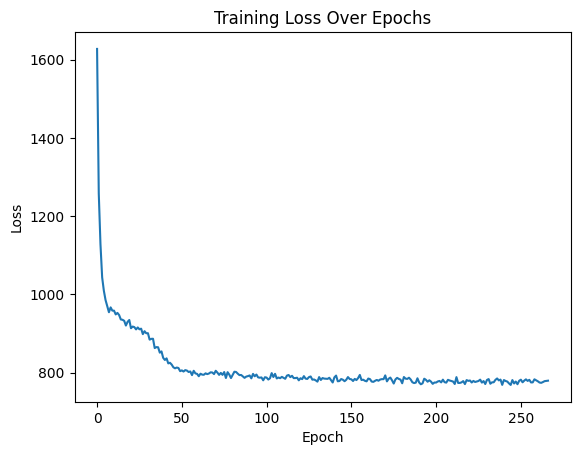

In [48]:
plt.plot(range(267), losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.show()

In [38]:
with torch.no_grad():
    reconstructed_test, mu_test, log_var_test = vae(X_test_tensor)

    # Предсказание на основе изменения 'close'
    predictions = ((reconstructed_test[:, -1, 4] > 0.5) == (X_test_tensor[:, -1, 4] > 0.5)).long()  # Сравниваем 'close' на последнем шаге

# Вычисление точности
accuracy = accuracy_score(reconstructed_test[:, -1, 4] > 0, (X_test_tensor[:, -1, 4] > 0))
print(f'Accuracy: {accuracy}')

Accuracy: 0.717391304347826


In [49]:
accuracy

0.45357142857142857

In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Пример многомерного временного ряда
# Предположим, что data_all — это DataFrame, содержащий множество признаков, включая 'close'

# Рассчитываем разницу (diff) только для столбца 'close'

data.dropna(inplace=True)  # Убираем NaN значения (первую строку, где разница NaN)

# Разделение на обучающую и тестовую выборку
size = int(len(data) * 0.66)  # 66% для обучения
train = data.iloc[:size]
test = data.iloc[size:]

# Определяем целевую переменную (разницу в 'close')
y_train = train['close_diff']
y_test = test['close_diff']

# Выбираем экзогенные переменные (например, 'open', 'high', 'low')
X_train = train[['open', 'high', 'low', 'volume']]  # Экзогенные переменные
X_test = test[['open', 'high', 'low', 'volume']]  # Экзогенные переменные

# Строим модель SARIMAX (ARIMA с экзогенными переменными)
model = SARIMAX(y_train, exog=X_train, order=(5, 1, 0))  # (p, d, q) параметры ARIMA
model_fit = model.fit(disp=0)

# Прогнозируем изменения для тестовой выборки
predictions = model_fit.forecast(steps=len(y_test), exog=X_test)

# Оценка точности: сравнение с реальными значениями разницы
correct_predictions = 0
total_predictions = 0

for t in range(len(y_test)):
    real_change = 1 if y_test.iloc[t] > 0 else 0  # 1 - рост, 0 - падение
    predicted_change = 1 if predictions.iloc[t] > 0 else 0  # Прогнозируем рост или падение

    if real_change == predicted_change:
        correct_predictions += 1  # Если прогноз совпал с реальностью

    total_predictions += 1  # Увеличиваем общее количество прогнозов

# Оценка точности модели
accuracy = correct_predictions / total_predictions * 100
error = mean_squared_error(y_test, predictions)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/stat

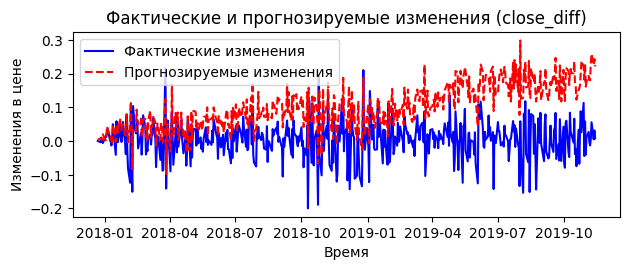

In [54]:
# График 1: Фактические vs Прогнозируемые изменения
plt.subplot(2, 1, 1)
plt.plot(y_test.index, y_test, label='Фактические изменения', color='blue')
plt.plot(y_test.index, predictions, label='Прогнозируемые изменения', color='red', linestyle='--')
plt.title('Фактические и прогнозируемые изменения (close_diff)')
plt.xlabel('Время')
plt.ylabel('Изменения в цене')
plt.legend()


# Показать графики
plt.tight_layout()
plt.show()

In [52]:
accuracy

59.66386554621849

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op

Test Accuracy: 50.63%
Test MSE: 0.004
Test MAE: 0.046


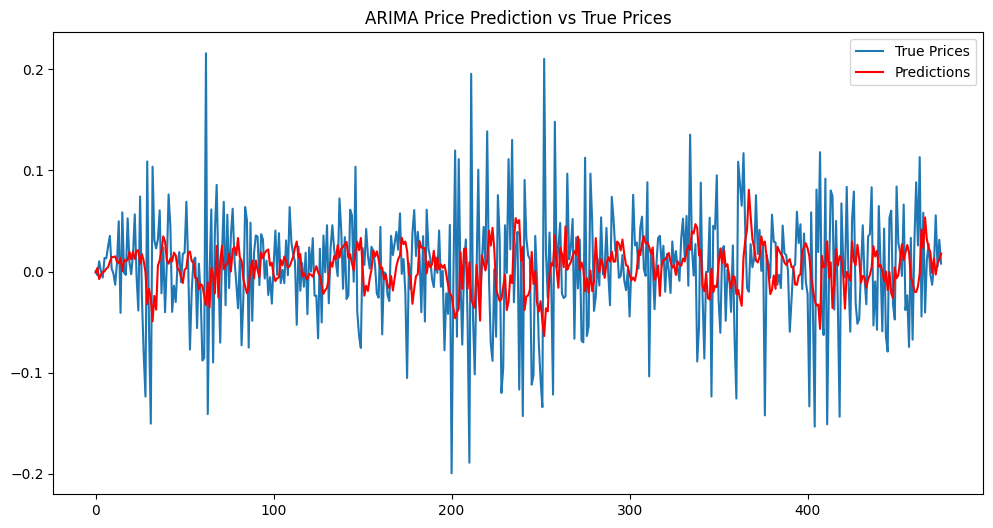

In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Инициализация счетчиков
correct_predictions = 0
total_predictions = 0

# Данные
X = data['close_diff'].values  # Предполагается, что 'data_all' содержит колонку 'close'
size = int(len(X) * 0.66)  # Размер обучающей выборки (66% данных)
train, test = X[0:size], X[size:len(X)]  # Разделение на обучающую и тестовую выборки
history = [x for x in train]  # Исторические данные для модели
predictions = list()  # Список для хранения прогнозов


# Прогнозирование
for t in range(len(test)):
    model = ARIMA(history, order=(5, 1, 0))  # Построение модели ARIMA
    model_fit = model.fit()  # Обучение модели
    output = model_fit.forecast()  # Прогнозирование
    yhat = output[0]  # Прогноз для следующего шага
    predictions.append(yhat)  # Добавление прогноза в список
    obs = test[t]  # Реальное значение

    # Обновление истории (для ARIMA)
    history.append(obs)

    # Сравнение прогнозов с реальностью
    if (obs>0) == (yhat>0):
        correct_predictions += 1  # Если прогноз совпал с реальностью
    total_predictions += 1  # Увеличиваем общее количество прогнозов

# Оценка точности модели
accuracy = correct_predictions / total_predictions * 100
error = mean_squared_error(test, predictions)
error_MAE = mean_absolute_error(test, predictions)

print(f'Test Accuracy: {accuracy:.2f}%')
print(f'Test MSE: {error:.3f}')
print(f'Test MAE: {error_MAE:.3f}')

# График прогнозов
plt.figure(figsize=(12, 6))
plt.plot(test, label='True Prices')
plt.plot(predictions, color='red', label='Predictions')
plt.legend()
plt.title('ARIMA Price Prediction vs True Prices')
plt.show()



Epoch 1/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - binary_output_accuracy: 0.5022 - binary_output_loss: 0.6937 - loss: 0.7079 - regression_output_loss: 0.0142 - regression_output_mae: 0.0886 - val_binary_output_accuracy: 0.5652 - val_binary_output_loss: 0.6790 - val_loss: 0.6893 - val_regression_output_loss: 0.0044 - val_regression_output_mae: 0.0452
Epoch 2/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - binary_output_accuracy: 0.5377 - binary_output_loss: 0.6885 - loss: 0.6962 - regression_output_loss: 0.0077 - regression_output_mae: 0.0514 - val_binary_output_accuracy: 0.5652 - val_binary_output_loss: 0.6793 - val_loss: 0.6877 - val_regression_output_loss: 0.0031 - val_regression_output_mae: 0.0360
Epoch 3/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - binary_output_accuracy: 0.4896 - binary_output_loss: 0.6960 - loss: 0.7021 - regression_output_loss: 0.0060 - regression_output_mae: 0.0479 - val_binary_output_accuracy: 0.5652 - val_binary_output_loss: 0.6781 - val_loss: 0.6878 - val_re

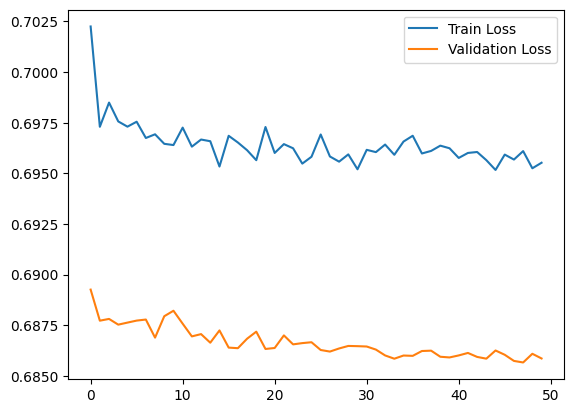

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Test Accuracy (Binary Classification): 56.52%


<ipython-input-126-5aae51f8fc3e>:75: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  accuracy = np.mean(binary_predictions.ravel() == y_test_binary.ravel())  # Сравниваем с реальной бинарной меткой


In [126]:
data_4 = data

# Нормализуем данные (не трогаем целевую переменную на этом этапе)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data_4)

# Создание бинарной метки: если цена выросла, то метка 1, если упала - 0
# Бинарная метка основывается на разнице между ценой закрытия в текущий день и следующем
y_binary = (data_4['close_diff']>0).astype(int)

# Создание набора данных для LSTM
look_back = 20  # Количество предыдущих дней для предсказания (можно увеличить)
X, y_regression = [], []

for i in range(len(scaled_data) - look_back):
    X.append(scaled_data[i:i + look_back])  # Входные данные (предыдущие дни)
    y_regression.append(scaled_data[i + look_back][3])  # Целевая переменная (закрытие на 21-й день)

X, y_regression = np.array(X), np.array(y_regression)

# Разделим на тренировочную и тестовую выборки (с учетом временной зависимости, shuffle=False)
X_train, X_test, y_train_regression, y_test_regression, y_train_binary, y_test_binary = train_test_split(
    X, y_regression, y_binary[look_back:], test_size=0.2, shuffle=False
)

# Строим модель LSTM для регрессии и бинарной классификации
input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))

# LSTM слой
lstm = LSTM(units=50, return_sequences=False)(input_layer)
lstm = Dropout(0.2)(lstm)  # Регуляризация (Dropout)

# Многозадачный выход:
# 1. Для бинарной классификации
binary_output = Dense(1, activation='sigmoid', name='binary_output')(lstm)

# 2. Для регрессии (предсказание цены)
regression_output = Dense(1, name='regression_output')(lstm)

# Создание модели с двумя выходами
model = Model(inputs=input_layer, outputs=[binary_output, regression_output])

# Компиляция модели с двумя функциями потерь
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss={'binary_output': 'binary_crossentropy', 'regression_output': 'mean_squared_error'},
    metrics={'binary_output': 'accuracy', 'regression_output': 'mae'}
)

# Обучаем модель
history = model.fit(
    X_train,
    {'binary_output': y_train_binary, 'regression_output': y_train_regression},
    epochs=50,
    batch_size=16,
    validation_data=(X_test, {'binary_output': y_test_binary, 'regression_output': y_test_regression})
)

# Оценка модели
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.show()

# Прогнозирование (прогнозируем цену на 21-й день и бинарную метку)
predictions = model.predict(X_test)

# Прогноз для бинарной классификации
binary_predictions = (predictions[0] > 0.5).astype(int)

# Оценка бинарной классификации (Accuracy)
accuracy = np.mean(binary_predictions.ravel() == y_test_binary.ravel())  # Сравниваем с реальной бинарной меткой
print(f"Test Accuracy (Binary Classification): {accuracy * 100:.2f}%")
